In [1]:
import os
import csv
import re
import pickle
import random
import math
import dicom
import numpy as np
from tqdm import tqdm
from natsort import natsorted
from skimage import transform
from sklearn.externals import joblib
from scipy import ndimage
from matplotlib import path

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_filepaths():
    with open('../../data_supp/filepaths_train.pkl', 'rb') as f:
        filepaths_train = pickle.load(f)
    with open('../../data_supp/filepaths_val.pkl', 'rb') as f:
        filepaths_val = pickle.load(f)
    return filepaths_train, filepaths_val

In [3]:
def get_training_labels():
    systole_labels = {}
    diastole_labels = {}
    with open('../../data/train.csv', 'r') as f:
        for _id, systole, diastole in csv.reader(f):
            if _id == 'Id':
                continue
            systole_labels[int(_id)] = float(systole)
            diastole_labels[int(_id)] = float(diastole)
    return systole_labels, diastole_labels

In [4]:
systole_labels, diastole_labels = get_training_labels()

# return tuple of real value and function represetation
def create_label(pt, mode='ED'):
    if mode == 'ES':
        return systole_labels[pt], systole_labels[pt] < np.arange(600)
    elif mode == 'ED':
        return diastole_labels[pt], diastole_labels[pt] < np.arange(600)
    else:
        raise

In [5]:
def apply_window(arr, window_center, window_width):
    return np.clip(arr, window_center - window_width/2, window_center + window_width/2)

In [6]:
def apply_per_slice_norm(arr):
    mean = np.mean(arr.ravel())
    std = np.std(arr.ravel())
    if std == 0:
        return np.zeros(arr.shape)
    return (arr - mean) / std

In [7]:
def crop_to_square_normalized(img_orig, pixel_spacing, size):
    img_norm = ndimage.interpolation.zoom(img_orig, [float(x) for x in pixel_spacing], order=0, mode='constant')
    
    length_x, length_y = img_norm.shape
    if length_x >= size:
        x_start = length_x // 2 - size // 2
        x_end = length_x // 2 + size // 2
    else:
        x_start = 0
        x_end = length_x
    if length_y >= size:
        y_start = length_y // 2 - size // 2
        y_end = length_y // 2 + size // 2
    else:
        y_start = 0
        y_end = length_y
    
    img_new = np.zeros((size, size))
    new_x_shift = (size - (x_end - x_start)) // 2
    new_y_shift = (size - (y_end - y_start)) // 2
    img_new[new_x_shift:(new_x_shift + x_end - x_start), 
            new_y_shift:(new_y_shift + y_end - y_start)] = img_norm[x_start:x_end, y_start:y_end]
    
    return img_new

In [8]:
def interp_vol3d(vol3d, z_locs, nb_slices_z):
    
    def find_interval(test_loc):
        for i in range(len(z_locs) - 1):
            if z_locs[i] <= test_loc <= z_locs[i+1]:
                return i
        return 0
        
    # vol3d shape is (depth, row, col)
    # z_locs are the slice locations corresponding to slices along the depth axis
    # we reshape through interpolation to nb_slices_z along the depth axis
    vol3d_new = np.zeros((nb_slices_z, vol3d.shape[1], vol3d.shape[2]))
    z_locs_new = [z_locs[0]]
    for i in range(1, nb_slices_z - 1):
        z_locs_new.append(z_locs[0] + i * (z_locs[-1] - z_locs[0]) / (nb_slices_z - 1))
    z_locs_new.append(z_locs[-1])
    
    for z, loc in enumerate(z_locs_new):
        if z == 0:
            vol3d_new[0, :, :] = vol3d[0, :, :]
        elif z == len(z_locs_new) - 1:
            vol3d_new[-1, :, :] = vol3d[-1, :, :]
        else:
            idx = find_interval(loc)
            z_loc_lower = z_locs[idx]
            z_loc_upper = z_locs[idx + 1]
            vol3d_new[z, :, :] = vol3d[idx, :, :] + ((loc - z_loc_lower) / (z_loc_upper - z_loc_lower)) * (vol3d[idx+1, :, :] - vol3d[idx, :, :])
            
    return vol3d_new
    

In [9]:
def get_all_series_filepaths(filepaths):
    t_slices = 30
    
    # create sax series filepaths
    # handles irregularies such as those including z-slices and t-slices in the same folder
    series_filepaths_all = []
    for view in filepaths.keys(): 
        if not re.match(r'^sax', view):
            continue
        
        if len(filepaths[view]) == t_slices:
            series_filepaths_all.append(filepaths[view])
        elif len(filepaths[view]) < t_slices:
            series_filepaths_all.append(filepaths[view][:] + filepaths[view][:(t_slices - len(filepaths[view]))])
        else:
            if re.match(r'^\w+-\d+-\d+-\d+.dcm$', filepaths[view][0][0]) is not None:
                series_filepaths_split = []
                slices_list = []
                series_filepaths_sort_by_slice = sorted(filepaths[view][:], 
                                                        key=lambda x: '{}-{}'.format(x[0].split('-')[-1].split('.')[0], 
                                                                                     x[0].split('-')[-2]))
                for fname, fpath in series_filepaths_sort_by_slice:
                    nslice = fname.split('-')[-1].split('.')[0]
                    tframe = fname.split('-')[-2]
                    if nslice not in slices_list:
                        if len(series_filepaths_split) == t_slices:
                            series_filepaths_all.append(series_filepaths_split)
                        elif len(series_filepaths_split) < t_slices and len(series_filepaths_split) > 0:
                            series_filepaths_all.append((series_filepaths_split[:] + 
                                                         series_filepaths_split[:(t_slices - len(series_filepaths_split))]))
                        series_filepaths_split = []
                        series_filepaths_split.append((fname, fpath))
                        slices_list.append(nslice)
                    else:
                        series_filepaths_split.append((fname, fpath))
                        
    return series_filepaths_all

In [10]:
filepaths_train, filepaths_val = get_filepaths()

### ES frame detection classifier

In [11]:
es_frame_clf = joblib.load('../../model_weights/ES_detection_GBR.pkl')

# assumes images are already cropped / normalized
def pred_es_frame(image_stack_series, img_size=256):
    seqs = []
    for image_stack in image_stack_series:
        nb_frames = 30
        if len(image_stack) != nb_frames:
            image_stack += image_stack[-1] * (30 - len(image_stack))

        mean_diff_seq = []
        img_ED = image_stack[0]
        for img_frame in image_stack[1:]:
            differences = []
            img_percent_diff = (img_frame - img_ED) / (img_ED + 1e-6)
            differences.append(np.mean(img_percent_diff))
            differences.append(np.mean(np.abs(img_percent_diff)))

            for scaling in [2, 4, 8]:
                for i in range(scaling):
                    for j in range(scaling):
                        differences.append(np.mean(img_percent_diff[(i*img_size//scaling):((i+1)*img_size//scaling), 
                                                                    (i*img_size//scaling):((i+1)*img_size//scaling)], 
                                                   axis=None))
                        differences.append(np.mean(np.abs(img_percent_diff[(i*img_size//scaling):((i+1)*img_size//scaling), 
                                                                           (i*img_size//scaling):((i+1)*img_size//scaling)]), 
                                                   axis=None))

            mean_diff_seq.append(differences)

        seqs.append(np.array(mean_diff_seq).astype(np.float32))
        
    preds = es_frame_clf.predict([x.ravel() for x in seqs])
    es_frame_pred = np.clip(np.round(np.mean(preds)), 1, nb_frames - 1)
    return es_frame_pred

In [12]:
pt_es_frame = {}

for pt in tqdm(filepaths_train.keys()):
    series_filepaths_all = get_all_series_filepaths(filepaths_train[pt])
    image_stack_series = []
    for series_filepaths in series_filepaths_all:
        image_stack = []
        for i, (fname, fpath) in enumerate(series_filepaths):
            df = dicom.read_file(fpath)
            image_stack.append(apply_per_slice_norm(crop_to_square_normalized(df.pixel_array, df.PixelSpacing, 256)))
        image_stack_series.append(image_stack)
    pt_es_frame[pt] = pred_es_frame(image_stack_series, img_size=256)
    
for pt in tqdm(filepaths_val.keys()):
    series_filepaths_all = get_all_series_filepaths(filepaths_val[pt])
    image_stack_series = []
    for series_filepaths in series_filepaths_all:
        image_stack = []
        for i, (fname, fpath) in enumerate(series_filepaths):
            df = dicom.read_file(fpath)
            image_stack.append(apply_per_slice_norm(crop_to_square_normalized(df.pixel_array, df.PixelSpacing, 256)))
        image_stack_series.append(image_stack)
    pt_es_frame[pt] = pred_es_frame(image_stack_series, img_size=256)

  6%|▌         | 28/500 [01:09<18:51,  0.42it/s]/opt/anaconda3/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:549: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [13]:
print(pt_es_frame[1])
print(pt_es_frame[501])

9.0
11.0


In [14]:
pt_es_frame = dict((k, int(v)) for k, v in pt_es_frame.items())

In [15]:
with open('../../data_supp/pt_es_frame.pkl', 'wb') as f:
    pickle.dump(pt_es_frame, f)

### LV segmentation net

In [16]:
from keras.models import Sequential, Graph
from keras.layers.core import Activation, Dense, Dropout, Flatten, Merge, Reshape, Lambda
from keras.layers.core import TimeDistributedDense, TimeDistributedMerge
from keras.layers.recurrent import LSTM, GRU
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU, PReLU, ParametricSoftplus, ELU
from keras.layers.normalization import BatchNormalization
from keras.layers.noise import GaussianDropout, GaussianNoise
from keras.utils import np_utils, generic_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import initializations
from keras.layers.core import Layer
from keras import backend as K

# for preventing python max recursion limit error
import sys
sys.setrecursionlimit(50000)

def RMSE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=None, keepdims=False))

def binaryCE(y_true, y_pred):
    return K.mean(K.binary_crossentropy(y_pred, y_true), axis=None, keepdims=False)

class Rotate90(Layer):
    def __init__(self, direction='clockwise', **kwargs):
        super(Rotate90, self).__init__(**kwargs)
        self.direction = direction

    def get_output(self, train):
        X = self.get_input(train)
        if self.direction == 'clockwise':
            return X.transpose((0, 2, 1))[:, :, ::-1]
        elif self.direction == 'counterclockwise':
            return X.transpose((0, 2, 1))[:, ::-1, :]
        else:
            raise

    def get_config(self):
        config = {"name": self.__class__.__name__}
        base_config = super(Rotate90, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
LV_model = Graph()

LV_model.add_input(name='input', input_shape=(1, 256, 256))

LV_model.add_node(Convolution2D(16, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-1-1', input='input')
LV_model.add_node(BatchNormalization(), name='conv-1-1-bn', input='conv-1-1')
LV_model.add_node(ELU(), name='conv-1-1-activ', input='conv-1-1-bn')
LV_model.add_node(Convolution2D(16, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-1-2', input='conv-1-1-activ')
LV_model.add_node(BatchNormalization(), name='conv-1-2-bn', input='conv-1-2')
LV_model.add_node(ELU(), name='conv-1-2-activ', input='conv-1-2-bn')
LV_model.add_node(MaxPooling2D(pool_size=(2,2), strides=None, border_mode='valid', dim_ordering='th'),
               name='pool-1', input='conv-1-2-activ')

LV_model.add_node(Convolution2D(32, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-2-1', input='pool-1')
LV_model.add_node(BatchNormalization(), name='conv-2-1-bn', input='conv-2-1')
LV_model.add_node(ELU(), name='conv-2-1-activ', input='conv-2-1-bn')
LV_model.add_node(Convolution2D(32, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-2-2', input='conv-2-1-activ')
LV_model.add_node(BatchNormalization(), name='conv-2-2-bn', input='conv-2-2')
LV_model.add_node(ELU(), name='conv-2-2-activ', input='conv-2-2-bn')
LV_model.add_node(MaxPooling2D(pool_size=(2,2), strides=None, border_mode='valid', dim_ordering='th'),
               name='pool-2', input='conv-2-2-activ')

LV_model.add_node(Convolution2D(64, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-3-1', input='pool-2')
LV_model.add_node(BatchNormalization(), name='conv-3-1-bn', input='conv-3-1')
LV_model.add_node(ELU(), name='conv-3-1-activ', input='conv-3-1-bn')
LV_model.add_node(Convolution2D(64, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-3-2', input='conv-3-1-activ')
LV_model.add_node(BatchNormalization(), name='conv-3-2-bn', input='conv-3-2')
LV_model.add_node(ELU(), name='conv-3-2-activ', input='conv-3-2-bn')
LV_model.add_node(Convolution2D(64, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-3-3', input='conv-3-2-activ')
LV_model.add_node(BatchNormalization(), name='conv-3-3-bn', input='conv-3-3')
LV_model.add_node(ELU(), name='conv-3-3-activ', input='conv-3-3-bn')
LV_model.add_node(MaxPooling2D(pool_size=(2,2), strides=None, border_mode='valid', dim_ordering='th'),
               name='pool-3', input='conv-3-3-activ')

LV_model.add_node(Convolution2D(128, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-4-1', input='pool-3')
LV_model.add_node(BatchNormalization(), name='conv-4-1-bn', input='conv-4-1')
LV_model.add_node(ELU(), name='conv-4-1-activ', input='conv-4-1-bn')
LV_model.add_node(Convolution2D(128, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-4-2', input='conv-4-1-activ')
LV_model.add_node(BatchNormalization(), name='conv-4-2-bn', input='conv-4-2')
LV_model.add_node(ELU(), name='conv-4-2-activ', input='conv-4-2-bn')
LV_model.add_node(Convolution2D(128, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-4-3', input='conv-4-2-activ')
LV_model.add_node(BatchNormalization(), name='conv-4-3-bn', input='conv-4-3')
LV_model.add_node(ELU(), name='conv-4-3-activ', input='conv-4-3-bn')
LV_model.add_node(MaxPooling2D(pool_size=(2,2), strides=None, border_mode='valid', dim_ordering='th'),
               name='pool-4', input='conv-4-3-activ')

LV_model.add_node(Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-5-1', input='pool-4')
LV_model.add_node(BatchNormalization(), name='conv-5-1-bn', input='conv-5-1')
LV_model.add_node(ELU(), name='conv-5-1-activ', input='conv-5-1-bn')
LV_model.add_node(Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-5-2', input='conv-5-1-activ')
LV_model.add_node(BatchNormalization(), name='conv-5-2-bn', input='conv-5-2')
LV_model.add_node(ELU(), name='conv-5-2-activ', input='conv-5-2-bn')
LV_model.add_node(Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-5-3', input='conv-5-2-activ')
LV_model.add_node(BatchNormalization(), name='conv-5-3-bn', input='conv-5-3')
LV_model.add_node(ELU(), name='conv-5-3-activ', input='conv-5-3-bn')
LV_model.add_node(MaxPooling2D(pool_size=(2,2), strides=None, border_mode='valid', dim_ordering='th'),
               name='pool-5', input='conv-5-3-activ')

LV_model.add_node(Flatten(), name='flatten', input='pool-5')
LV_model.add_node(Dense(4096, activation='relu'), name='fc-1', input='flatten')
LV_model.add_node(Dropout(0.5), name='dropout-1', input='fc-1')
LV_model.add_node(Dense(4096, activation='relu'), name='fc-2', input='dropout-1')
LV_model.add_node(Dropout(0.5), name='dropout-2', input='fc-2')
LV_model.add_node(Reshape((64, 8, 8)), name='reshape', input='dropout-2')

LV_model.add_node(UpSampling2D(size=(2, 2), dim_ordering='th'), name='unpool-1', input='reshape')
LV_model.add_node(Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-1-1', input='unpool-1')
LV_model.add_node(BatchNormalization(), name='deconv-1-1-bn', input='deconv-1-1')
LV_model.add_node(ELU(), name='deconv-1-1-activ', input='deconv-1-1-bn')
LV_model.add_node(Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-1-2', input='deconv-1-1-activ')
LV_model.add_node(BatchNormalization(), name='deconv-1-2-bn', input='deconv-1-2')
LV_model.add_node(ELU(), name='deconv-1-2-activ', input='deconv-1-2-bn')
LV_model.add_node(Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-1-3', input='deconv-1-2-activ')
LV_model.add_node(BatchNormalization(), name='deconv-1-3-bn', input='deconv-1-3')
LV_model.add_node(ELU(), name='deconv-1-3-activ', input='deconv-1-3-bn')

LV_model.add_node(UpSampling2D(size=(2, 2), dim_ordering='th'), name='unpool-2', input='deconv-1-3-activ')
LV_model.add_node(Convolution2D(128, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-2-1', input='unpool-2')
LV_model.add_node(BatchNormalization(), name='deconv-2-1-bn', input='deconv-2-1')
LV_model.add_node(ELU(), name='deconv-2-1-activ', input='deconv-2-1-bn')
LV_model.add_node(Convolution2D(128, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-2-2', input='deconv-2-1-activ')
LV_model.add_node(BatchNormalization(), name='deconv-2-2-bn', input='deconv-2-2')
LV_model.add_node(ELU(), name='deconv-2-2-activ', input='deconv-2-2-bn')
LV_model.add_node(Convolution2D(128, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-2-3', input='deconv-2-2-activ')
LV_model.add_node(BatchNormalization(), name='deconv-2-3-bn', input='deconv-2-3')
LV_model.add_node(ELU(), name='deconv-2-3-activ', input='deconv-2-3-bn')

LV_model.add_node(UpSampling2D(size=(2, 2), dim_ordering='th'), name='unpool-3', input='deconv-2-3-activ')
LV_model.add_node(Convolution2D(64, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-3-1', input='unpool-3')
LV_model.add_node(BatchNormalization(), name='deconv-3-1-bn', input='deconv-3-1')
LV_model.add_node(ELU(), name='deconv-3-1-activ', input='deconv-3-1-bn')
LV_model.add_node(Convolution2D(64, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-3-2', input='deconv-3-1-activ')
LV_model.add_node(BatchNormalization(), name='deconv-3-2-bn', input='deconv-3-2')
LV_model.add_node(ELU(), name='deconv-3-2-activ', input='deconv-3-2-bn')
LV_model.add_node(Convolution2D(64, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-3-3', input='deconv-3-2-activ')
LV_model.add_node(BatchNormalization(), name='deconv-3-3-bn', input='deconv-3-3')
LV_model.add_node(ELU(), name='deconv-3-3-activ', input='deconv-3-3-bn')

LV_model.add_node(UpSampling2D(size=(2, 2), dim_ordering='th'), name='unpool-4', input='deconv-3-3-activ')
LV_model.add_node(Convolution2D(32, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-4-1', input='unpool-4')
LV_model.add_node(BatchNormalization(), name='deconv-4-1-bn', input='deconv-4-1')
LV_model.add_node(ELU(), name='deconv-4-1-activ', input='deconv-4-1-bn')
LV_model.add_node(Convolution2D(32, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-4-2', input='deconv-4-1-activ')
LV_model.add_node(BatchNormalization(), name='deconv-4-2-bn', input='deconv-4-2')
LV_model.add_node(ELU(), name='deconv-4-2-activ', input='deconv-4-2-bn')

LV_model.add_node(UpSampling2D(size=(2, 2), dim_ordering='th'), name='unpool-5', input='deconv-4-2-activ')
LV_model.add_node(Convolution2D(16, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-5-1', input='unpool-5')
LV_model.add_node(BatchNormalization(), name='deconv-5-1-bn', input='deconv-5-1')
LV_model.add_node(ELU(), name='deconv-5-1-activ', input='deconv-5-1-bn')
LV_model.add_node(Convolution2D(16, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-5-2', input='deconv-5-1-activ')
LV_model.add_node(BatchNormalization(), name='deconv-5-2-bn', input='deconv-5-2')
LV_model.add_node(ELU(), name='deconv-5-2-activ', input='deconv-5-2-bn')

LV_model.add_node(Convolution2D(1, 1, 1, activation='sigmoid', init='uniform', border_mode='same', dim_ordering='th'),
               name='prob-map', input='deconv-5-2-activ')
LV_model.add_node(Reshape((256, 256)), name='prob-map-reshape', input='prob-map')
LV_model.add_node(Dropout(0.5), name='prob-map-dropout', input='prob-map-reshape')

LV_model.add_node(GRU(256, activation='tanh', inner_activation='hard_sigmoid', return_sequences=True),
               name='rnn-we', input='prob-map-dropout')
LV_model.add_node(GRU(256, activation='tanh', inner_activation='hard_sigmoid', go_backwards=True, return_sequences=True),
               name='rnn-ew', input='prob-map-dropout')
LV_model.add_node(TimeDistributedDense(256, init='uniform', activation='sigmoid'),
               name='rnn-1', inputs=['rnn-we', 'rnn-ew'], merge_mode='concat', concat_axis=-1)

LV_model.add_node(Rotate90(direction='counterclockwise'), name='rotate', input='prob-map-dropout')
LV_model.add_node(GRU(256, activation='tanh', inner_activation='hard_sigmoid', return_sequences=True),
               name='rnn-ns', input='rotate')
LV_model.add_node(GRU(256, activation='tanh', inner_activation='hard_sigmoid', go_backwards=True, return_sequences=True),
               name='rnn-sn', input='rotate')
LV_model.add_node(TimeDistributedDense(256, init='uniform', activation='sigmoid'),
               name='rnn-2-rotated', inputs=['rnn-ns', 'rnn-sn'], merge_mode='concat', concat_axis=-1)
LV_model.add_node(Rotate90(direction='clockwise'), name='rnn-2', input='rnn-2-rotated')

LV_model.add_node(Activation('linear'), name='pre-output', inputs=['rnn-1', 'rnn-2'], merge_mode='mul')
LV_model.add_output(name='output', input='pre-output')

LV_model.compile('adam', {'output': binaryCE})

LV_model.load_weights('../../model_weights/manual_001-100_plus_sunnybrook_segmentation.hdf5')

Using Theano backend.


Using gpu device 3: Tesla K80 (CNMeM is disabled)


In [17]:
def pred_segment_mask(image_stack):
    return LV_model.predict({'input': np.expand_dims(np.array(image_stack).astype(np.float32), axis=1)}, 
                            verbose=0)['output']

### preprocess data

In [18]:
with open('../../data_supp/pt_es_frame.pkl', 'rb') as f:
    pt_es_frame = pickle.load(f)

In [19]:
train_val_split = 0.05
pts_train_val = random.sample(list(range(1, 501)), int(500 * train_val_split))
pts_train = list(set(range(1, 501)) - set(pts_train_val))

In [20]:
def create_volumes_sax(filepaths, img_size=256, normalize_nb_slices=True, nb_slices_z=12, frame=0):
    series_filepaths_all = get_all_series_filepaths(filepaths)
    
    if normalize_nb_slices:
                        
        # sort series by z-locations
        z_locs = []
        for series_filepaths in series_filepaths_all:
            df = dicom.read_file(series_filepaths[0][1])
            z_locs.append(df.SliceLocation)
        series_filepaths_all_zsorted = [series_filepaths for (loc, series_filepaths) in sorted(zip(z_locs, 
                                                                                                   series_filepaths_all), 
                                                                                               key=lambda pair: pair[0])]
        z_locs = sorted(z_locs)

        # create 3d volumes
        vol3d = []
        for series_filepaths in series_filepaths_all_zsorted:
            fname, fpath = natsorted(series_filepaths, lambda x: x[0])[frame]
            df = dicom.read_file(fpath)
            img2d = apply_per_slice_norm(crop_to_square_normalized(df.pixel_array, df.PixelSpacing, img_size))
            vol3d.append(img2d.astype(np.float32))
        vol3d_mask = pred_segment_mask(vol3d)
        vol3d = interp_vol3d(np.array(vol3d).astype(np.float32), z_locs, nb_slices_z)
        vol3d = [np.expand_dims(vol3d[i].astype(np.float32), axis=0) for i in range(len(vol3d))]
        vol3d_mask = interp_vol3d(vol3d_mask, z_locs, nb_slices_z)
        vol3d_mask = [np.expand_dims(vol3d_mask[i,:,:].astype(np.float32), axis=0) for i in range(vol3d_mask.shape[0])]

        return vol3d, vol3d_mask
    
    else:
        # MIP
        
        vol3d = []
        for series_filepaths in series_filepaths_all:
            fname, fpath = natsorted(series_filepaths, lambda x: x[0])[frame]
            df = dicom.read_file(fpath)
            img2d = apply_per_slice_norm(crop_to_square_normalized(df.pixel_array, df.PixelSpacing, img_size))
            vol3d.append(img2d.astype(np.float32))
        vol3d_mask = pred_segment_mask(vol3d)
        
        vol3d_MIP = np.mean(np.array(vol3d), axis=0)
        vol3d_mask_MIP = np.mean(vol3d_mask, axis=0)
        
        return vol3d_MIP, vol3d_mask_MIP

In [22]:
img_size = 256

# training
data_ED_train = []
data_ES_train = []
labels_value_ED_train = []
labels_value_ES_train = []
labels_func_ED_train = []
labels_func_ES_train = []

# training local validation
data_ED_train_val = []
data_ES_train_val = []
labels_value_ED_train_val = []
labels_value_ES_train_val = []
labels_func_ED_train_val = []
labels_func_ES_train_val = []

# validation
data_ED_val = []
data_ES_val = []
data_val_pt_index = []

for pt in tqdm(filepaths_train.keys()):
    vol3d_MIP_ED, vol3d_mask_MIP_ED = create_volumes_sax(filepaths_train[pt], 
                                                 img_size=img_size, 
                                                 normalize_nb_slices=False,
                                                 frame=0)
    vol3d_MIP_ES, vol3d_mask_MIP_ES = create_volumes_sax(filepaths_train[pt], 
                                                 img_size=img_size, 
                                                 normalize_nb_slices=False,
                                                 frame=pt_es_frame[pt])
    
    label_value_ES, label_func_ES = create_label(pt, mode='ES')
    label_value_ED, label_func_ED = create_label(pt, mode='ED')
    
    if pt in pts_train:
        data_ED_train.append(vol3d_MIP_ED)
        data_ES_train.append(vol3d_MIP_ES)
        data_ED_train.append(vol3d_mask_MIP_ED)
        data_ES_train.append(vol3d_mask_MIP_ES)
        labels_value_ED_train.append(label_value_ED)
        labels_value_ES_train.append(label_value_ES)
        labels_func_ED_train.append(label_func_ED)
        labels_func_ES_train.append(label_func_ES)
    elif pt in pts_train_val:
        data_ED_train_val.append(vol3d_MIP_ED)
        data_ES_train_val.append(vol3d_MIP_ES)
        data_ED_train_val.append(vol3d_mask_MIP_ED)
        data_ES_train_val.append(vol3d_mask_MIP_ES)
        labels_value_ED_train_val.append(label_value_ED)
        labels_value_ES_train_val.append(label_value_ES)
        labels_func_ED_train_val.append(label_func_ED)
        labels_func_ES_train_val.append(label_func_ES)

        
for pt in tqdm(filepaths_val.keys()):
    vol3d_MIP_ED, vol3d_mask_MIP_ED = create_volumes_sax(filepaths_val[pt], 
                                                 img_size=img_size, 
                                                 normalize_nb_slices=False,
                                                 frame=0)
    vol3d_MIP_ES, vol3d_mask_MIP_ES = create_volumes_sax(filepaths_val[pt], 
                                                 img_size=img_size, 
                                                 normalize_nb_slices=False,
                                                 frame=pt_es_frame[pt])
        
    data_ED_val.append(vol3d_MIP_ED)
    data_ES_val.append(vol3d_MIP_ES)
    data_ED_val.append(vol3d_mask_MIP_ED)
    data_ES_val.append(vol3d_mask_MIP_ES)

    data_val_pt_index.append(int(pt))

data_ED_train = np.array(data_ED_train).astype(np.float32)
data_ES_train = np.array(data_ES_train).astype(np.float32)
labels_value_ED_train = np.array(labels_value_ED_train).astype(np.float32)
labels_value_ES_train = np.array(labels_value_ES_train).astype(np.float32)
labels_func_ED_train = np.array(labels_func_ED_train).astype(np.bool)
labels_func_ES_train = np.array(labels_func_ES_train).astype(np.bool)
print(data_ED_train.shape, data_ES_train.shape, 
      labels_value_ED_train.shape, labels_value_ES_train.shape,
      labels_func_ED_train.shape, labels_func_ES_train.shape)


data_ED_train_val = np.array(data_ED_train_val).astype(np.float32)
data_ES_train_val = np.array(data_ES_train_val).astype(np.float32)
labels_value_ED_train_val = np.array(labels_value_ED_train_val).astype(np.float32)
labels_value_ES_train_val = np.array(labels_value_ES_train_val).astype(np.float32)
labels_func_ED_train_val = np.array(labels_func_ED_train_val).astype(np.bool)
labels_func_ES_train_val = np.array(labels_func_ES_train_val).astype(np.bool)
print(data_ED_train_val.shape, data_ES_train_val.shape, 
      labels_value_ED_train_val.shape, labels_value_ES_train_val.shape,
      labels_func_ED_train_val.shape, labels_func_ES_train_val.shape)

data_ED_val = np.array(data_ED_val).astype(np.float32)
data_ES_val = np.array(data_ES_val).astype(np.float32)
data_val_pt_index = np.array(data_val_pt_index).astype(np.uint16)
print(data_ED_val.shape, data_ES_val.shape, 
      data_val_pt_index.shape)

  6%|▌         | 28/500 [00:40<11:12,  0.70it/s]/opt/anaconda3/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:549: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
                                                 

(950, 256, 256) (950, 256, 256) (475,) (475,) (475, 600) (475, 600)
(50, 256, 256) (50, 256, 256) (25,) (25,) (25, 600) (25, 600)
(400, 256, 256) (400, 256, 256) (200,)


In [23]:
joblib.dump((pts_train, pts_train_val, 
             data_ED_train, data_ES_train, 
             labels_value_ED_train, labels_value_ES_train, labels_func_ED_train, labels_func_ES_train, 
             data_ED_train_val, data_ES_train_val, 
             labels_value_ED_train_val, labels_value_ES_train_val, labels_func_ED_train_val, labels_func_ES_train_val, 
             data_ED_val, data_ES_val, data_val_pt_index), 
            '../../data_proc/data_with_base_masks.pkl')

['../../data_proc/data_with_base_masks.pkl',
 '../../data_proc/data_with_base_masks.pkl_01.npy',
 '../../data_proc/data_with_base_masks.pkl_02.npy',
 '../../data_proc/data_with_base_masks.pkl_03.npy',
 '../../data_proc/data_with_base_masks.pkl_04.npy',
 '../../data_proc/data_with_base_masks.pkl_05.npy',
 '../../data_proc/data_with_base_masks.pkl_06.npy',
 '../../data_proc/data_with_base_masks.pkl_07.npy',
 '../../data_proc/data_with_base_masks.pkl_08.npy',
 '../../data_proc/data_with_base_masks.pkl_09.npy',
 '../../data_proc/data_with_base_masks.pkl_10.npy',
 '../../data_proc/data_with_base_masks.pkl_11.npy',
 '../../data_proc/data_with_base_masks.pkl_12.npy',
 '../../data_proc/data_with_base_masks.pkl_13.npy',
 '../../data_proc/data_with_base_masks.pkl_14.npy',
 '../../data_proc/data_with_base_masks.pkl_15.npy']

### Plots

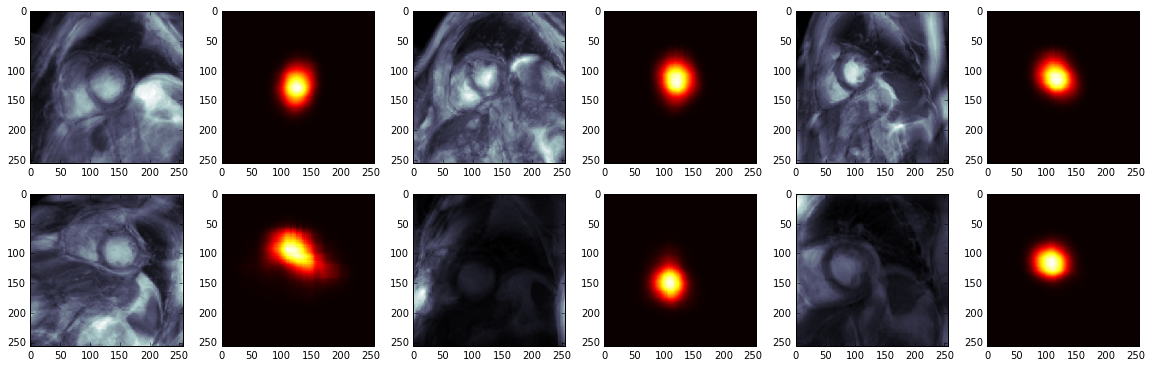

In [29]:
plt.figure(figsize=(20,6))    
for s in range(12):
    plt.subplot(2, 6, s+1)
    if s%2 == 0:
        plt.imshow(data_ED_train[s], cmap=plt.cm.bone)
    else:
        plt.imshow(data_ED_train[s], cmap=plt.cm.hot)

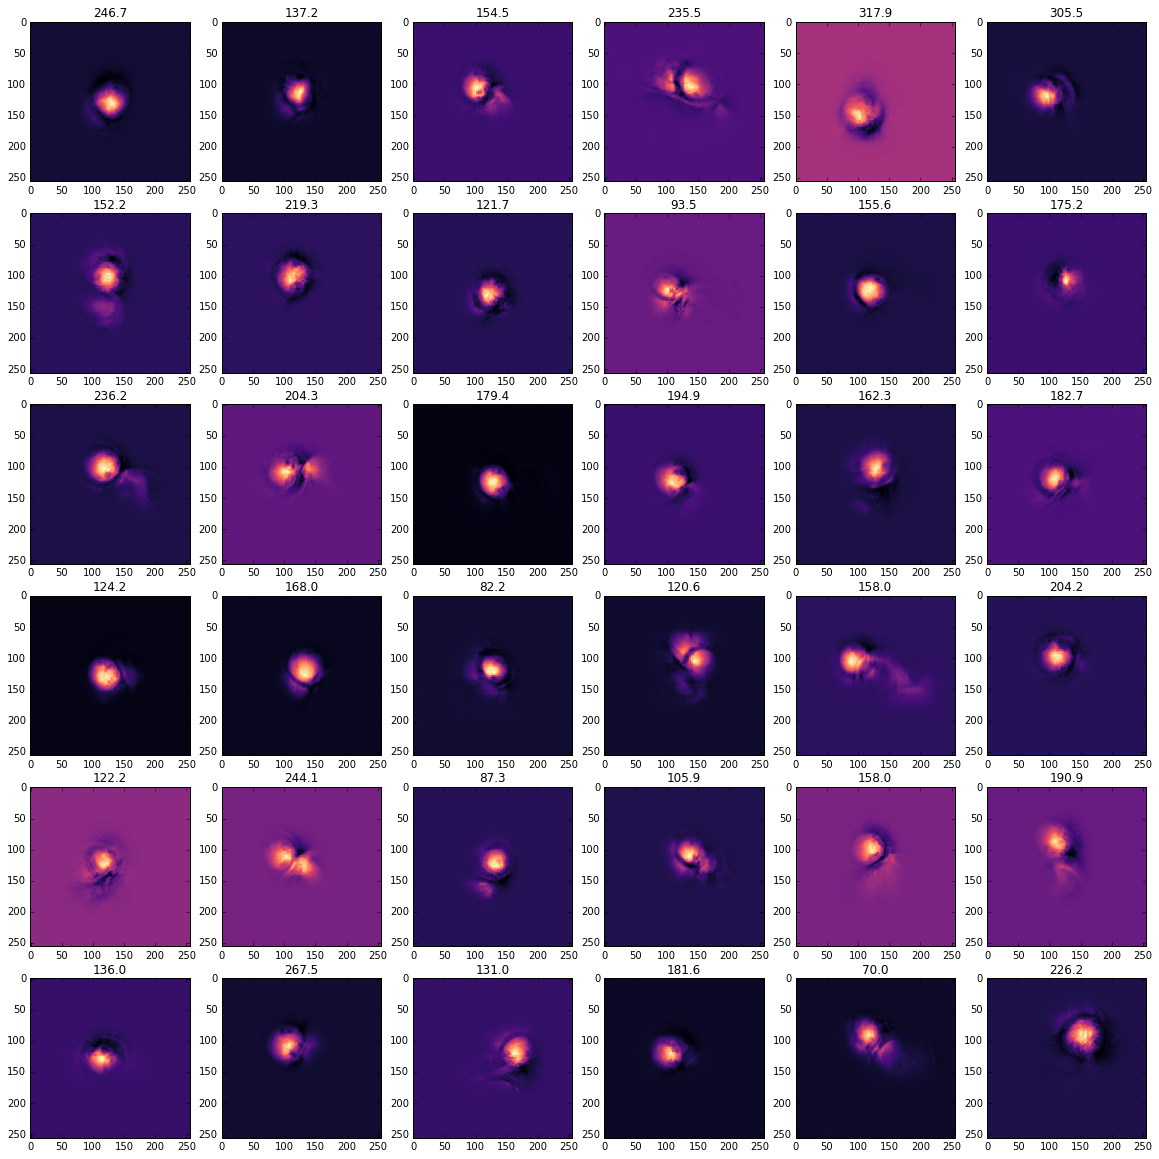

In [36]:
plt.figure(figsize=(20,20))    
for i in range(36):
    plt.subplot(6, 6, i+1)
    plt.title(labels_value_ED_train[i])
    plt.imshow((data_ED_train[i*2] * data_ED_train[i*2+1]), cmap=plt.cm.magma)

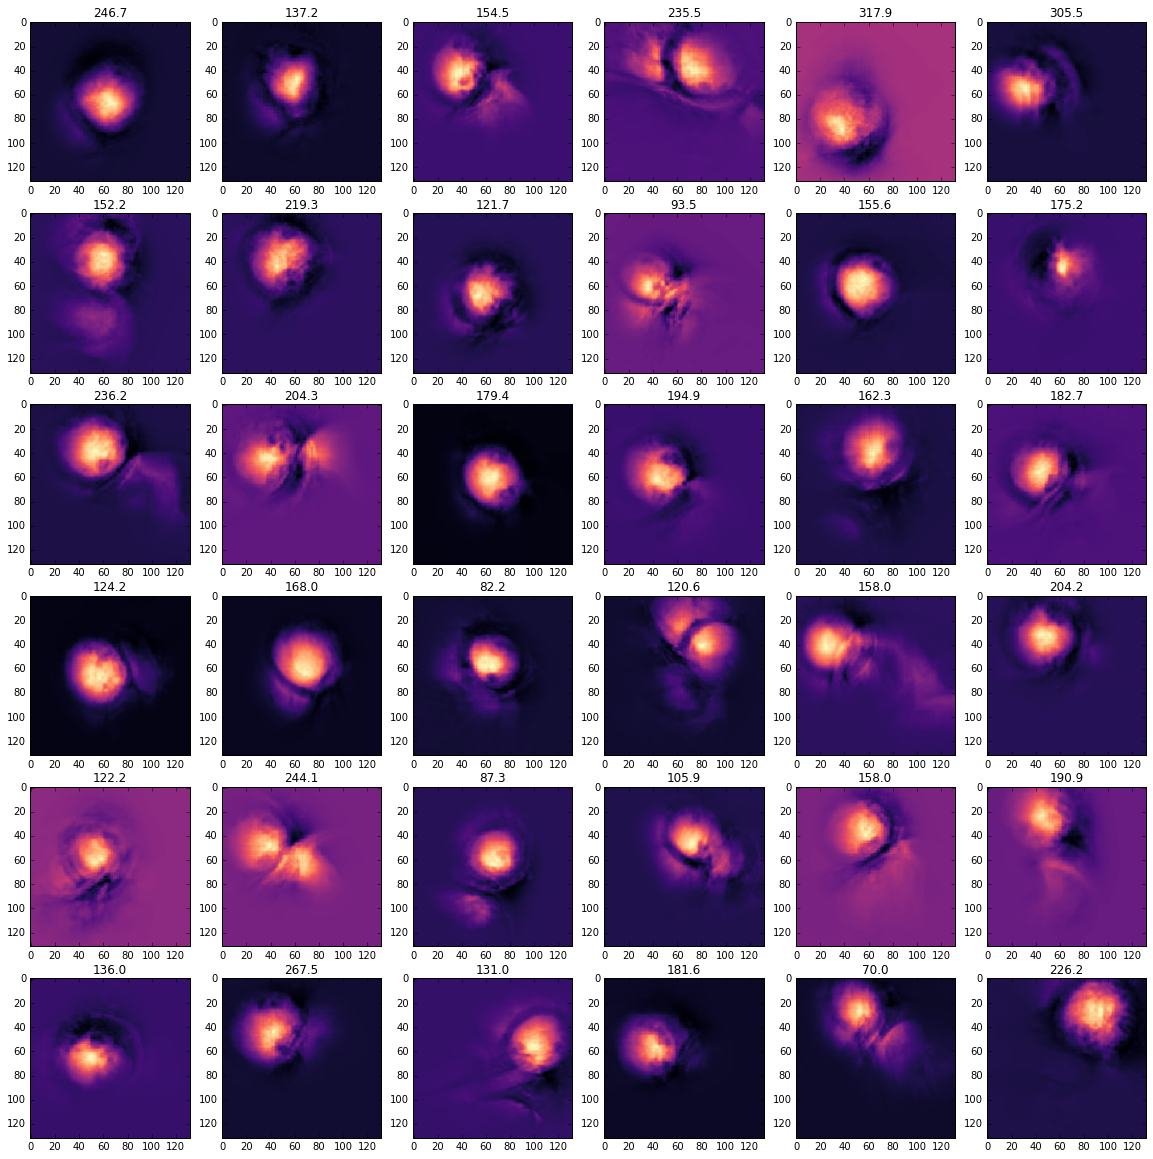

In [103]:
plt.figure(figsize=(20,20))    
for i in range(36):
    plt.subplot(6, 6, i+1)
    plt.title(labels_value_ED_train[i])
    plt.imshow((data_ED_train[i*2] * data_ED_train[i*2+1] / np.max(data_ED_train[i*2+1]))[64:196, 64:196], cmap=plt.cm.magma)

### use MIP for further segmentation using random walker

/opt/anaconda3/lib/python3.5/site-packages/skimage/util/dtype.py:111: UserWarning: Possible precision loss when converting from float32 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


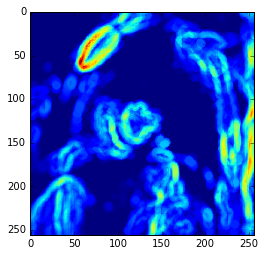

In [239]:
from skimage.filters import rank
from skimage.morphology import watershed, disk

i = 8
img_MIP_norm = data_ED_train[i*2] / np.max(data_ED_train[i*2] )
mask_MIP_norm = data_ED_train[i*2+1] / np.max(data_ED_train[i*2+1])
img_masked_MIP = img_MIP_norm * mask_MIP_norm
img_masked_MIP /= np.max(img_masked_MIP)

gradient = rank.gradient(img_MIP_norm, disk(4))
plt.imshow(gradient)

#markers = rank.gradient(img_MIP_norm, disk()) < 3
#markers = ndimage.label(markers)[0]

#markers = np.zeros(img_masked_MIP.shape, dtype=np.bool)
#markers[img_masked_MIP > 0.1] = True
#markers[np.random.choice([True, False], img_masked_MIP.shape, p=(0.01,0.99)) * (img_masked_MIP > 0.5)] = 2
#plt.imshow(watershed(gradient, markers))

#labels = random_walker(img_MIP_norm, markers, beta=10, mode='bf')
#plt.imshow(img_MIP_norm * (labels - 1), interpolation='nearest', cmap=plt.cm.magma)

In [61]:
labels

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ..., 
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)